In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import ResultS

In [3]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [4]:
# Do not forget to set the radius for centeral nodes calculation
# The minimum trip distance is considered 1000m and this can be modified through utils.py: generate_demand function. 
# long attribute should be calculated according to the size of city
# Platform fare is 2$ per km

params = MaaSSim.utils.get_config('glance.json')
params.use_fixed_postions = True
params.times.patience = 600 #in second
params.dist_threshold = 10000 #in meter
params.vehicle_fixed_positions= True  #this should be fixed
params.city = "Delft, Netherland"
params.paths.G = "../../data/graphs/Delft.graphml"
params.paths.skim = "../../data/graphs/Delft.csv"
params.nP = 500
params.nV = 20
params.simTime =5

In [5]:
sim= MaaSSim.simulators.simulate(params=params)

12-11-21 11:56:02-WARNING-Setting up 5h simulation at 2021-11-12 09:26:12 for 20 vehicles and 500 passengers in Delft, Netherland
12-11-21 11:56:02-INFO--------------------	Starting simulation	-------------------
12-11-21 11:56:02-INFO-pax    1  got to dest at                           2021-11-12 09:32:56
12-11-21 11:56:02-INFO-pax    8  got to dest at                           2021-11-12 09:33:24
12-11-21 11:56:02-INFO-pax    7  got to dest at                           2021-11-12 09:33:25
12-11-21 11:56:02-INFO-pax    5  got to dest at                           2021-11-12 09:33:44
12-11-21 11:56:02-INFO-pax    0  got to dest at                           2021-11-12 09:34:12
12-11-21 11:56:02-INFO-pax   11  got to dest at                           2021-11-12 09:34:32
12-11-21 11:56:02-INFO-pax    2  got to dest at                           2021-11-12 09:35:09
12-11-21 11:56:02-INFO-pax    3  got to dest at                           2021-11-12 09:36:00
12-11-21 11:56:02-INFO-pax    4  go

In [7]:
sim.acceptance_attributes

""


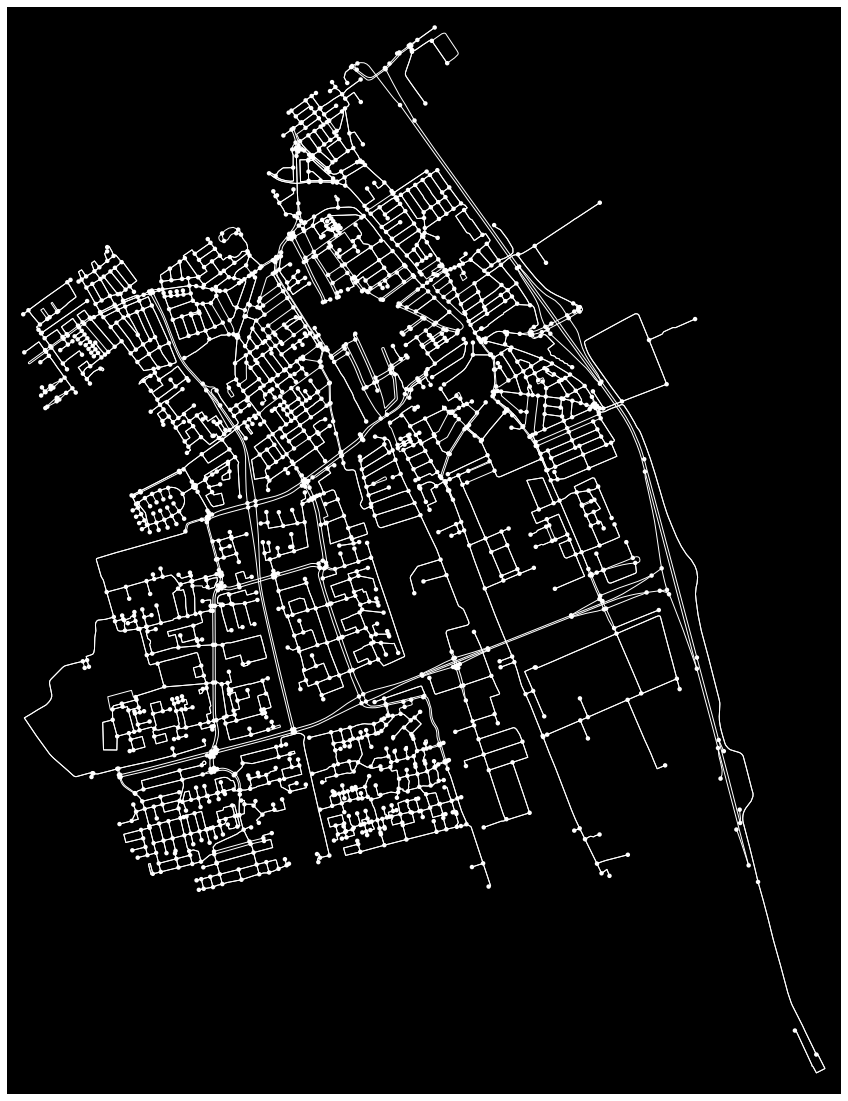

In [6]:
#No need to run
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(20, 20), show=False, close=False, node_size=20, bgcolor='black', edge_color='w')

Number of centeral nodes:  464


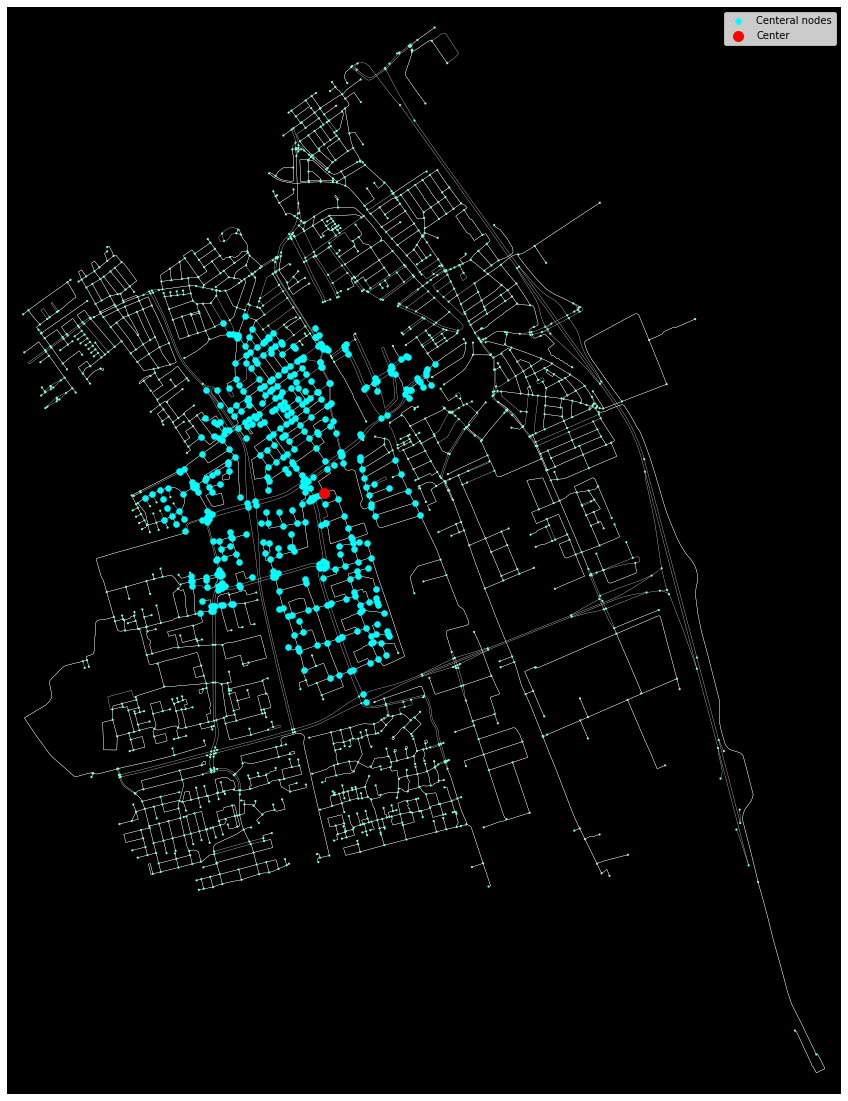

In [6]:
#No need to run
centeral_nodes = sim.inData.stats.central_nodes

l_x=[]
l_y=[]

for i in centeral_nodes:
    l_x.append(sim.inData.G.nodes[i]['x'])
    l_y.append(sim.inData.G.nodes[i]['y'])

print('Number of centeral nodes: ', len(l_x))

fig, ax = ox.plot_graph(sim.inData.G, figsize=(20, 20), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=l_x, y=l_y,c='aqua',linewidths=0.5, label='Centeral nodes')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='red',linewidths=5,
                   label='Center')

plt.legend()

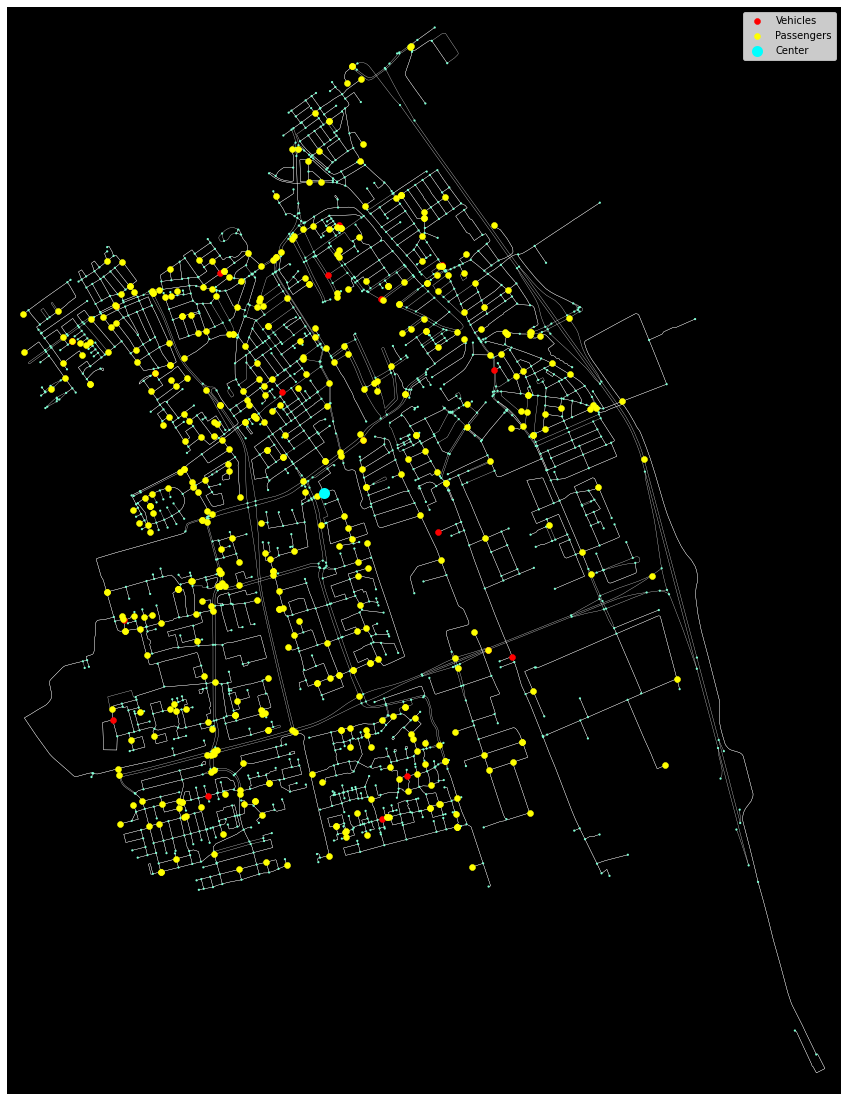

In [8]:
vehicles_position = sim.vehicle_fixed_positions
veh_lx=[]
veh_ly=[]
for i in vehicles_position:
    veh_lx.append(sim.inData.G.nodes[i]['x'])
    veh_ly.append(sim.inData.G.nodes[i]['y'])
    
passengers_position = sim.inData.passengers.pos
pass_lx=[]
pass_ly=[]
for i in passengers_position:
    pass_lx.append(sim.inData.G.nodes[i]['x'])
    pass_ly.append(sim.inData.G.nodes[i]['y'])

fig, ax = ox.plot_graph(sim.inData.G, figsize=(20, 20), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=veh_lx, y=veh_ly,c='red',linewidths=0.5, label='Vehicles')
scat = plt.scatter(x=pass_lx, y=pass_ly,c='yellow',linewidths=0.5, label='Passengers')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='aqua',linewidths=5,
                   label='Center')

plt.legend()

In [6]:
r_def= ResultS(sim)

In [7]:
r_def.requests

,veh_id,n_of_requests,n_of_accepted,n_of_declined,acceptance_rate %
0,1,12,12,0,100.0
1,2,24,24,0,100.0
2,3,25,25,0,100.0
3,4,29,29,0,100.0
4,5,28,28,0,100.0
5,6,24,24,0,100.0
6,7,23,23,0,100.0
7,8,28,28,0,100.0
8,9,27,27,0,100.0
9,10,13,13,0,100.0


In [8]:
r_def.trips

,veh_id,pax_id,pickup_t[min],pickup_d[km],travel_t_with[min],pax_km,travel_t[min],travel_d[km],veh_waiting_t[sec],revenue $
0,1,0,3.066667,1.84,4.016667,2.41,7.583333,4.55,0,4.82
1,1,23,0.916667,0.55,6.983333,4.19,8.400000,5.04,176,8.38
2,1,52,1.100000,0.66,3.783333,2.27,5.383333,3.23,587,4.54
3,1,66,1.900000,1.14,4.666667,2.80,7.066667,4.24,604,5.60
4,1,91,0.733333,0.44,6.350000,3.81,7.583333,4.55,473,7.62
...,...,...,...,...,...,...,...,...,...,...
24,20,424,2.150000,1.29,3.900000,2.34,6.550000,3.93,54,4.68
25,20,435,4.550000,2.73,5.616667,3.37,10.666667,6.40,73,6.74
26,20,460,1.566667,0.94,4.783333,2.87,6.850000,4.11,10,5.74
27,20,459,5.383333,3.23,5.066667,3.04,10.950000,6.57,10,6.08


In [9]:
r_def.passengers

,pax_id,veh_id,waiting_t[sec],number of declines
0,0,1.0,0,0
1,1,8.0,0,0
2,2,16.0,0,0
3,3,17.0,0,0
4,4,7.0,0,0
...,...,...,...,...
495,495,19.0,7,0
496,496,15.0,58,0
497,497,9.0,0,0
498,498,7.0,53,0


In [10]:
r_def.passengers['waiting_t[sec]'].mean()

29.312

In [23]:
# 50% & 50% Primary BIP implemented on First regime 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap

sim.acceptance_attributes = pd.DataFrame()

def f_decline(veh, **kwargs):
    
    if veh.id > sim.params.nV/2:
        return False
    else:
        df = pd.DataFrame(veh.myrides)
        ASC = 1.810                                                                                   #ASC
    
        working_shift = veh.veh['shift_end'] - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']
    
        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0
        
        if veh.veh['pos'] in sim.inData.stats.centeral_nodes:
            loc = 1
        else:
            loc = 0
        
        
        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 
    
        surge_price = 0                                                                               #surge_price
    
        req = 1                         #req                                                          #req_long_rate_dec
    
        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0
        
        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
        if last_declined == 'True':
            dec = 1
        else:
            dec = 0
        
           
        V = ((ASC*1) + (Time1*loc*(-0.303)) + (pickup_time*(-0.050)) + (waiting_time*(-0.017)) + 
            ((req*long*rate*dec)*0.091) + (surge_price*0.101))
    
    
        acc_prob = (math.exp(V))/(1+math.exp(V))

        attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 
                             'Time1_loc':[Time1*loc*(-0.303)], 'pickup_time':[pickup_time*(-0.050)],
                             'waiting_t':[waiting_time], 'surge_price':[surge_price*0.101], 
                             'req_long_rate_dec':[req*long*rate*dec*0.091], 'P':[acc_prob]})
        sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

12-11-21 12:40:33-INFO--------------------	Starting simulation	-------------------
12-11-21 12:40:33-WARNING-pax   12  got rejected by vehicle 4                2021-11-12 09:30:53
12-11-21 12:40:33-INFO-pax    1  got to dest at                           2021-11-12 09:32:56
12-11-21 12:40:33-WARNING-pax   16  got rejected by vehicle 8                2021-11-12 09:33:18
12-11-21 12:40:33-INFO-pax    8  got to dest at                           2021-11-12 09:33:24
12-11-21 12:40:33-INFO-pax    7  got to dest at                           2021-11-12 09:33:25
12-11-21 12:40:33-INFO-pax    5  got to dest at                           2021-11-12 09:33:44
12-11-21 12:40:33-WARNING-pax   18  got rejected by vehicle 2                2021-11-12 09:34:01
12-11-21 12:40:33-WARNING-pax   18  got rejected by vehicle 3                2021-11-12 09:34:01
12-11-21 12:40:33-INFO-pax    0  got to dest at                           2021-11-12 09:34:12
12-11-21 12:40:33-INFO-pax   11  got to dest at            

In [34]:
df = sim.acceptance_attributes
df = df[df['pickup_time']>-7]
df

,pax_id,veh_id,Time1_loc,pickup_time,waiting_t,surge_price,req_long_rate_dec,P
0,0.0,1,-0.0,-0.236667,0.000000,0.0,0.0,0.828258
0,1.0,5,-0.0,-0.085000,0.183333,0.0,0.0,0.848371
0,2.0,6,-0.0,-0.046667,0.383333,0.0,0.0,0.852811
0,3.0,10,-0.0,-0.173333,1.033333,0.0,0.0,0.834671
0,5.0,3,-0.0,-0.016667,2.183333,0.0,0.0,0.852735
...,...,...,...,...,...,...,...,...
0,492.0,8,-0.0,-0.170000,2.533333,0.0,0.0,0.831589
0,495.0,5,-0.0,-0.071667,5.266667,0.0,0.0,0.838729
0,496.0,1,-0.0,-0.132500,22.216667,0.0,0.0,0.785804
0,498.0,4,-0.0,-0.044167,6.316667,0.0,0.0,0.840030


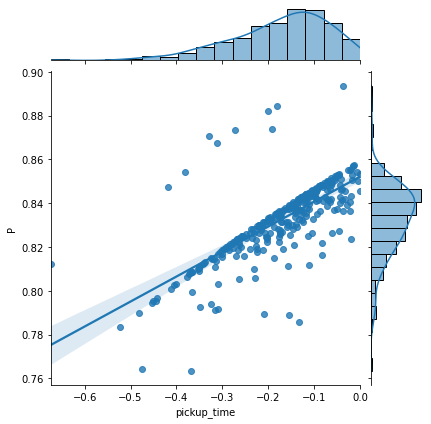

In [32]:
sns.jointplot(x=df['pickup_time'], y=df['P'], kind='reg')

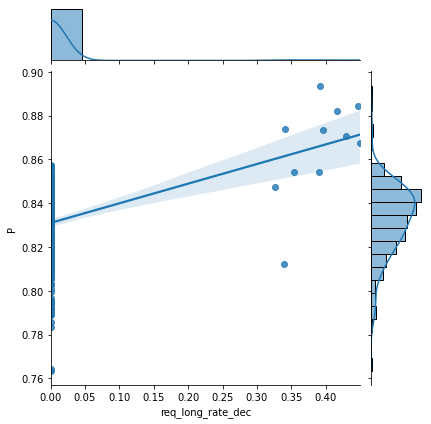

In [35]:
sns.jointplot(x=df['req_long_rate_dec'], y=df['P'], kind='reg')

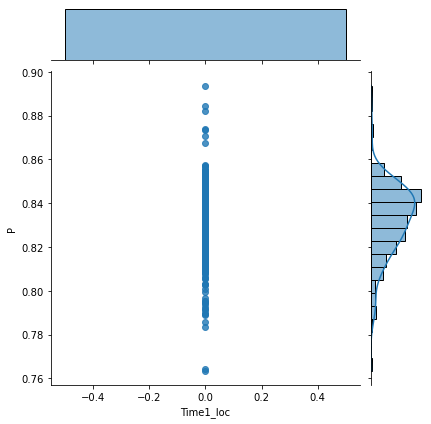

In [36]:
sns.jointplot(x=df['Time1_loc'], y=df['P'], kind='reg')

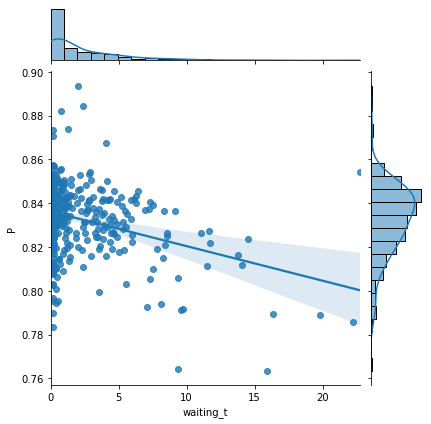

In [37]:
sns.jointplot(x=df['waiting_t'], y=df['P'], kind='reg')

In [17]:
r_5050= ResultS(sim)

In [18]:
r_5050.requests

,veh_id,n_of_requests,n_of_accepted,n_of_declined,acceptance_rate %
0,1,36,30,6,83.333333
1,2,39,29,10,74.358974
2,3,35,27,8,77.142857
3,4,37,27,10,72.972973
4,5,26,23,3,88.461538
5,6,36,26,10,72.222222
6,7,37,26,11,70.270270
7,8,31,26,5,83.870968
8,9,32,24,8,75.000000
9,10,38,28,10,73.684211


In [19]:
r_5050.trips

,veh_id,pax_id,pickup_t[min],pickup_d[km],travel_t_with[min],pax_km,travel_t[min],travel_d[km],veh_waiting_t[sec],revenue $
0,1,0,5.516667,3.31,4.066667,2.44,10.083333,6.05,0,4.88
1,1,17,2.216667,1.33,5.700000,3.42,8.416667,5.05,14,6.84
2,1,31,7.133333,4.28,9.016667,5.41,16.650000,9.99,139,10.82
3,1,55,3.283333,1.97,3.200000,1.92,6.983333,4.19,69,3.84
4,1,70,1.900000,1.14,7.383333,4.43,9.783333,5.87,71,8.86
...,...,...,...,...,...,...,...,...,...,...
8,20,174,0.966667,0.58,7.883333,4.73,9.350000,5.61,10,9.46
9,20,188,2.833333,1.70,2.966667,1.78,6.300000,3.78,137,3.56
10,20,205,3.416667,2.05,4.950000,2.97,8.866667,5.32,56,5.94
11,20,233,4.650000,2.79,3.450000,2.07,8.600000,5.16,265,4.14


In [20]:
r_5050.trips.groupby(['veh_id']).sum()

,pax_id,pickup_t[min],pickup_d[km],travel_t_with[min],pax_km,travel_t[min],travel_d[km],veh_waiting_t[sec],revenue $
veh_id,,,,,,,,,
1,7396,89.516667,53.71,127.883333,76.73,232.550000,139.53,3426,153.46
2,7084,83.016667,49.81,131.133333,78.68,228.700000,137.22,3632,157.36
3,7571,66.566667,39.94,136.366667,81.82,216.883333,130.13,4631,163.64
4,7168,88.783333,53.27,121.216667,72.73,223.500000,134.10,4079,145.46
5,6349,80.116667,48.07,115.466667,69.28,207.083333,124.25,4852,138.56
6,7437,69.683333,41.81,122.966667,73.78,205.650000,123.39,4756,147.56
7,6680,69.233333,41.54,116.166667,69.70,198.400000,119.04,5335,139.40
8,7278,70.016667,42.01,133.466667,80.08,216.483333,129.89,4371,160.16
9,6108,79.083333,47.45,123.333333,74.00,214.416667,128.65,4772,148.00


In [21]:
picky_drivers = r_5050.trips.groupby(['veh_id']).sum().iloc[0:10].sum()
ok_drivers = r_5050.trips.groupby(['veh_id']).sum().iloc[10:21].sum()

print('The sum for drivers employing acceptance function is ', picky_drivers)
print('---------------------------------------------------------')
print('---------------------------------------------------------')
print('The sum for drivers accepting all requests is ', ok_drivers)

The sum for drivers employing acceptance function is  pax_id                70596.000000
pickup_t[min]           770.733333
pickup_d[km]            462.440000
travel_t_with[min]     1245.350000
pax_km                  747.210000
travel_t[min]          2149.733333
travel_d[km]           1289.840000
veh_waiting_t[sec]    44810.000000
revenue $              1494.420000
dtype: float64
---------------------------------------------------------
---------------------------------------------------------
The sum for drivers accepting all requests is  pax_id                53303.000000
pickup_t[min]          1144.950000
pickup_d[km]            686.970000
travel_t_with[min]     1104.266667
pax_km                  662.560000
travel_t[min]          2364.866667
travel_d[km]           1418.920000
veh_waiting_t[sec]    33969.000000
revenue $              1325.120000
dtype: float64


In [22]:
r_5050.passengers

,pax_id,veh_id,waiting_t[sec],number of declines
0,0,1.0,0,0
1,1,16.0,0,0
2,2,12.0,0,0
3,3,7.0,0,0
4,4,15.0,0,0
...,...,...,...,...
495,495,1.0,113,0
496,496,3.0,0,0
497,497,13.0,0,0
498,498,17.0,0,0


In [23]:
r_5050.passengers['waiting_t[sec]'].mean()

37.32

In [63]:
params.times.patience = 3600

In [73]:
params.nP = 500
params.nV = 20
params.simTime = 1

In [78]:
sim= MaaSSim.simulators.simulate(params=params)

11-11-21 11:29:45-WARNING-Setting up 1h simulation at 2021-11-11 10:59:54 for 20 vehicles and 500 passengers in Delft, Netherland
11-11-21 11:29:46-INFO--------------------	Starting simulation	-------------------
11-11-21 11:29:46-INFO-pax    6  got to dest at                           2021-11-11 11:04:05
11-11-21 11:29:46-INFO-pax    7  got to dest at                           2021-11-11 11:04:45
11-11-21 11:29:46-INFO-pax    9  got to dest at                           2021-11-11 11:05:31
11-11-21 11:29:46-INFO-pax    2  got to dest at                           2021-11-11 11:06:46
11-11-21 11:29:46-INFO-pax    0  got to dest at                           2021-11-11 11:06:59
11-11-21 11:29:46-INFO-pax   31  got to dest at                           2021-11-11 11:07:12
11-11-21 11:29:46-INFO-pax    8  got to dest at                           2021-11-11 11:07:40
11-11-21 11:29:47-INFO-pax    1  got to dest at                           2021-11-11 11:07:41
11-11-21 11:29:47-INFO-pax    5  go

In [79]:
r = ResultS(sim)

In [84]:
r.requests['n_of_accepted'].mean()

18.8

In [85]:
r.trips['revenue $'].sum()

1996.4399999999998

In [81]:
r.trips['travel_t[min]'].mean()

5.904210992907806

In [54]:
# 50% & 50% Primary BIP implemented on First regime 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


dist_lim = sim.requests['dist'].quantile(0.5)

def f_decline(veh, **kwargs):
    
    if veh.id > sim.params.nV/2:
        return False
    else:
        df = pd.DataFrame(veh.myrides)
    
        travel_dist = veh.offers[0]["request"]["dist"]
           

        if travel_dist > dist_lim:
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

11-11-21 11:02:53-INFO--------------------	Starting simulation	-------------------
11-11-21 11:02:53-WARNING-pax    1  got rejected by vehicle 15               2021-11-11 10:32:29
11-11-21 11:02:53-WARNING-pax    1  got rejected by vehicle 16               2021-11-11 10:32:29
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 15               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 19               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 16               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 18               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 14               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    4  got rejected by vehicle 12               2021-11-11 10:32:36
11-11-21 11:02:53-WARNING-pax    5  got rejected by vehicle 10               2021-11-11 10:32:45
11-11-21 11:02:53-WARNING-pax    5  got reje

In [55]:
r_my = ResultS(sim)

In [56]:
r_my.requests

,veh_id,n_of_requests,n_of_accepted,n_of_declined,acceptance_rate %
0,1,13,13,0,100.000000
1,2,15,15,0,100.000000
2,3,14,14,0,100.000000
3,4,14,14,0,100.000000
4,5,13,13,0,100.000000
5,6,14,14,0,100.000000
6,7,13,13,0,100.000000
7,8,9,9,0,100.000000
8,9,14,14,0,100.000000
9,10,60,7,53,11.666667


In [57]:
r_my.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV/2)].sum()

pax_id                64788.000000
pickup_t[min]            79.400000
pickup_d[km]             47.640000
travel_t_with[min]      510.966667
pax_km                  306.580000
travel_t[min]           663.433333
travel_d[km]            398.060000
veh_waiting_t[sec]     1320.000000
revenue $               613.160000
dtype: float64

In [58]:
r_my.trips.groupby(['veh_id']).sum().iloc[int(params.nV/2):int(params.nV+1)].sum()

pax_id                35414.000000
pickup_t[min]           265.383333
pickup_d[km]            159.230000
travel_t_with[min]      490.950000
pax_km                  294.570000
travel_t[min]           792.866667
travel_d[km]            475.720000
veh_waiting_t[sec]     1284.000000
revenue $               589.140000
dtype: float64

<AxesSubplot:xlabel='pax_id', ylabel='veh_waiting_t[min]'>

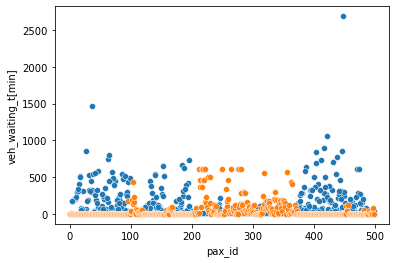

In [22]:
rr = r_5050

sns.scatterplot(data=rr.trips, x='pax_id', y='veh_waiting_t[min]')
sns.scatterplot(data=rr.passengers, x='pax_id', y='waiting_t[sec]')

Issues with the acceptance function:

1- If there is an attribute in the function it should be really used otherwise we should remove it from the model like surge fee.

2- the attribues should be matched to the environment and they should create the same impact as they have on the SP environment
